In [1]:
import pandas as pd
import numpy as np

In [2]:
import xgboost as xgb

In [3]:
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

C:\Users\Sudhansu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# Load in the train and test datasets
train = pd.read_csv('C:/Users/Sudhansu/Documents/Loan/train.csv')
test = pd.read_csv('C:/Users/Sudhansu/Documents/Loan/test.csv')
train['DOB'] = pd.to_datetime(train['DOB'])
test['DOB']= pd.to_datetime(test['DOB'])

In [6]:
train.head(3)

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,Female,1979-07-23,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
1,APPD40611263344,Male,1986-07-12,04/07/16,C10003,A,COM0000002,C,1.0,3500.0,...,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
2,APPE70289249423,Male,1982-10-12,19/07/16,C10125,C,COM0005267,C,4.0,2250.0,...,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0


In [7]:
# Store our passenger ID for easy access
Id = test['ID']

In [8]:
full_data = [train, test]

print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69713 entries, 0 to 69712
Data columns (total 22 columns):
ID                                     69713 non-null object
Gender                                 69713 non-null object
DOB                                    69698 non-null datetime64[ns]
Lead_Creation_Date                     69713 non-null object
City_Code                              68899 non-null object
City_Category                          68899 non-null object
Employer_Code                          65695 non-null object
Employer_Category1                     65695 non-null object
Employer_Category2                     65415 non-null float64
Monthly_Income                         69713 non-null float64
Customer_Existing_Primary_Bank_Code    60322 non-null object
Primary_Bank_Type                      60322 non-null object
Contacted                              69713 non-null object
Source                                 69713 non-null object
Source_Category            

In [9]:
for dataset in full_data:
    # Mapping Gender
    dataset['Gender'] = dataset['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
        

In [10]:
train.head(3)

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,0,1979-07-23,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
1,APPD40611263344,1,1986-07-12,04/07/16,C10003,A,COM0000002,C,1.0,3500.0,...,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
2,APPE70289249423,1,1982-10-12,19/07/16,C10125,C,COM0005267,C,4.0,2250.0,...,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0


In [11]:
for dataset in full_data:
    #Mapping Contacted
    dataset['Contacted'] = dataset['Contacted'].map( {'N': 0, 'Y': 1} ).astype(int)
    
    #Mapping Source_category
    source_category_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
    dataset['Source_Category'] = dataset['Source_Category'].map(source_category_mapping)
    dataset['Source_Category'] = dataset['Source_Category'].fillna(0)
    
    #Mapping City_category
    city_category_mapping = {"A": 1, "B": 2, "C": 3}
    dataset['City_Category'] = dataset['City_Category'].map(city_category_mapping)
    dataset['City_Category'] = dataset['City_Category'].fillna(0)
    
    #Mapping Employer Category1
    employer1_category_mapping = {"A": 1, "B": 2, "C": 3}
    dataset['Employer_Category1'] = dataset['Employer_Category1'].map(employer1_category_mapping)
    dataset['Employer_Category1'] = dataset['Employer_Category1'].fillna(0)
    
    #Mapping Employer Category2
    dataset['Employer_Category2'] = dataset['Employer_Category2'].fillna(0)
    
    #Mapping Primary Bank Type
    primary_banktype_mapping = {"P": 1, "G": 2}
    dataset['Primary_Bank_Type'] = dataset['Primary_Bank_Type'].map(primary_banktype_mapping)
    dataset['Primary_Bank_Type'] = dataset['Primary_Bank_Type'].fillna(0)

In [12]:
import warnings
warnings.filterwarnings('ignore')
for dataset in full_data:
    Loan_Amount_avg  = dataset['Loan_Amount'].mean()
    Loan_Amount_std  = dataset['Loan_Amount'].std()
    Loan_Amount_null_count = dataset['Loan_Amount'].isnull().sum()
    
    Loan_Amount_null_random_list = np.random.randint(Loan_Amount_avg - Loan_Amount_std, Loan_Amount_avg + Loan_Amount_std, size=Loan_Amount_null_count)
    dataset['Loan_Amount'][np.isnan(dataset['Loan_Amount'])] = Loan_Amount_null_random_list
    dataset['Loan_Amount'] = dataset['Loan_Amount'].astype(int)
    

In [13]:
for dataset in full_data:
    EMI_avg  = dataset['EMI'].mean()
    EMI_std  = dataset['EMI'].std()
    EMI_null_count = dataset['EMI'].isnull().sum()
    
    EMI_null_random_list = np.random.randint(EMI_avg - EMI_std, EMI_avg + EMI_std, size=EMI_null_count)
    dataset['EMI'][np.isnan(dataset['EMI'])] = EMI_null_random_list
    dataset['EMI'] = dataset['EMI'].astype(int)

In [14]:
for dataset in full_data:
    dataset['Existing_EMI'] = dataset ['Existing_EMI'].replace(np.nan, 0)
    dataset['Existing_EMI'] = dataset['Existing_EMI'].astype(int)

In [15]:
for dataset in full_data:
    dataset['TotalEMI'] = dataset['EMI'] + dataset['Existing_EMI'] 

In [16]:
for dataset in full_data:
    dataset['TotalEMItoIncomeRatio'] = (dataset['TotalEMI'] / (dataset['Monthly_Income']+1))

In [17]:
for dataset in full_data:
    dataset['LoantoIncomeRatio'] = (dataset['Loan_Amount'] / (dataset['Monthly_Income']+1))

In [18]:
for dataset in full_data:
    dataset['EMItoIncomeRatio'] = (dataset['EMI'] / (dataset['Monthly_Income']+1))

In [19]:
for dataset in full_data:
    dataset['Age'] = 2018 - dataset['DOB'].dt.year

In [20]:
for dataset in full_data:
    dataset.loc[ dataset['Age'] <= 18, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 30), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 50, 'Age']                           = 4

In [21]:
for dataset in full_data:
    Age_avg  = dataset['Age'].mean()
    Age_std  = dataset['Age'].std()
    Age_null_count = dataset['Age'].isnull().sum()
    
    Age_null_random_list = np.random.randint(Age_avg - Age_std, Age_avg + Age_std, size=Age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = Age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [22]:
# Feature selection
drop_elements = ['ID', 'DOB', 'Lead_Creation_Date', 'City_Code', 'Employer_Code', 'Customer_Existing_Primary_Bank_Code', 'Source', 'Loan_Period', 'Interest_Rate' ]
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [23]:
train.head(3)
test.isnull().sum()

Gender                   0
City_Category            0
Employer_Category1       0
Employer_Category2       0
Monthly_Income           0
Primary_Bank_Type        0
Contacted                0
Source_Category          0
Existing_EMI             0
Loan_Amount              0
EMI                      0
Var1                     0
TotalEMI                 0
TotalEMItoIncomeRatio    0
LoantoIncomeRatio        0
EMItoIncomeRatio         0
Age                      0
dtype: int64

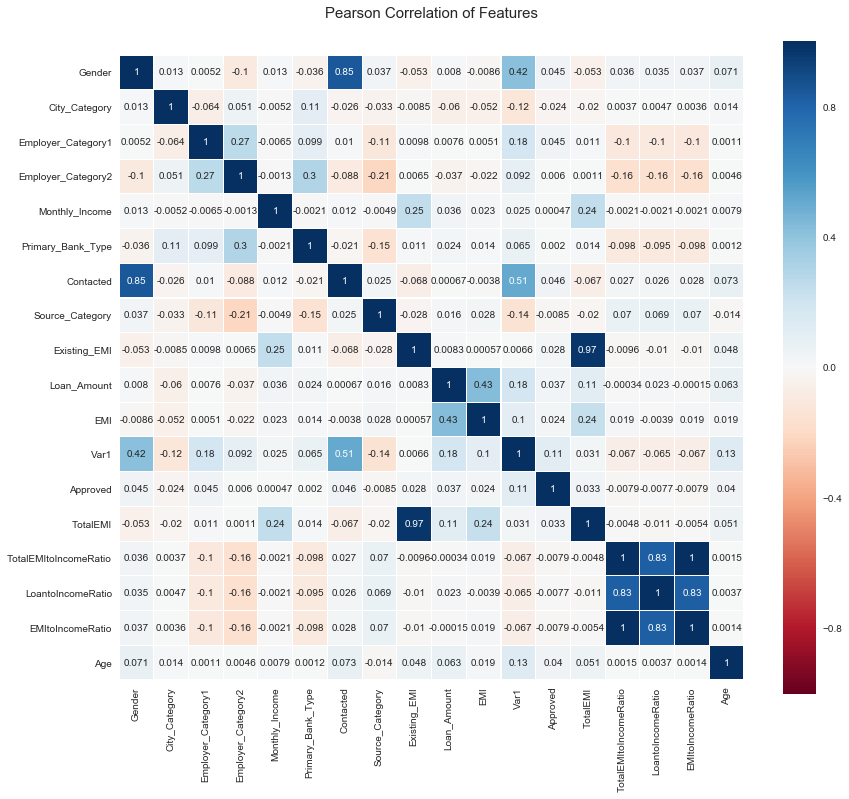

In [24]:
# Correlation plots
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [25]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [26]:
# Out of Fold Prediction
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [27]:
# five learning models as our first level classification: Random Forest classifier, Extra Trees classifier
# AdaBoost classifer, Gradient Boosting classifer, Support Vector Machine

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 50,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 50,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}


In [28]:
# Create objects for models
#rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
#et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
#ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
#svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [29]:
# Create train, test ( Approved) dataframes 
y_train = train['Approved'].ravel()
train = train.drop(['Approved'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [30]:
# Train and Test predictions. 
#et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
#rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test)
#ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test)
#svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test)

print("Training complete")

Training complete


In [31]:
base_predictions_train = pd.DataFrame( {
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,GradientBoost
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [32]:
gbm = xgb.XGBClassifier(
 n_estimators= 200,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [33]:
# Generate Submission File 
Submission = pd.DataFrame({ 'Id': Id,
                            'Approved': predictions })
Submission.to_csv("Submission.csv", index=False)